In [1]:
!wget http://www.ivan-sipiran.com/downloads/covid_dataset.zip
!unzip covid_dataset.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: covid_dataset/train/ababe608-9aa0-4055-8a0b-6ecd96b84b54.png  
  inflating: covid_dataset/train/abb7db92-8361-49a9-9d87-d7091beb6ef2.png  
  inflating: covid_dataset/train/abbefda5-54df-4e52-b716-50fe19fff3b9.png  
  inflating: covid_dataset/train/abc07cd4-2d0f-4ad8-a516-b45d035dadb1.png  
  inflating: covid_dataset/train/abc5356a-b8b2-4a0b-9dab-14c54efb4f29.png  
  inflating: covid_dataset/train/abc7cc15-0123-4640-a14f-aba7c6451520.png  
  inflating: covid_dataset/train/abca299e-57c0-4eff-b785-39d690cd2c7e.png  
  inflating: covid_dataset/train/abcb43a2-7b1d-428a-b909-e54c92acbd5b.png  
  inflating: covid_dataset/train/abcc9e5e-29c2-4961-a783-873aa706006d.png  
  inflating: covid_dataset/train/abcf4625-f1e7-4d11-a3ca-4aa242504120.png  
  inflating: covid_dataset/train/abd4e52c-39a9-401d-b0ee-7d94f4597fae.png  
  inflating: covid_dataset/train/abd50515-15ea-489a-bdb8-c38dd3ef0b36.png  
  inflating: covid_da

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import os
import copy
from torchvision.io import read_image
from PIL import Image


In [3]:
class CovidDataset(torch.utils.data.Dataset):
  def __init__(self, root, split, transform):
    self.root = root
    self.split = split
    self.transform = transform
    self.class2idx = dict()

    self.class2idx['pneumonia'] = 0
    self.class2idx['COVID-19'] = 1
    self.class2idx['normal'] = 2

    self.classes = ['pneumonia','COVID-19','normal']
    dataset_file = os.path.join(self.root, f'{self.split}_split_v3.txt')
    with open(dataset_file, 'r') as f:
      lines = f.readlines()

    self.images = []
    self.labels = []

    for line in lines:
      line = line.strip()
      output = line.split(' ')
      self.images.append(output[1])
      self.labels.append(output[2])

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image_path = os.path.join(self.root, self.split, self.images[idx])
    image = Image.open(image_path)
    label = self.class2idx[self.labels[idx]]
    im = image.convert('RGB')

    if self.transform:
      image = self.transform(im)

    return image, label


dataset = CovidDataset(root='covid_dataset/', split='train',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize((0.5,),(0.5,))

                                                ]))



(tensor([[[-0.7993, -0.7479, -0.7479,  ..., -1.8953, -2.0152, -1.9980],
         [-0.9363, -0.8507, -0.7650,  ..., -0.7308, -1.9638, -2.0665],
         [-1.0562, -0.9877, -0.9020,  ...,  0.1768, -1.1075, -1.8610],
         ...,
         [ 0.2796,  0.2967,  0.2111,  ...,  1.3070,  1.3755,  1.5297],
         [ 0.2282,  0.1939,  0.1426,  ...,  1.3927,  1.4098,  1.4954],
         [ 0.2624,  0.1939,  0.1768,  ...,  1.3070,  1.3070,  1.2728]],

        [[-0.6877, -0.6352, -0.6352,  ..., -1.8081, -1.9307, -1.9132],
         [-0.8277, -0.7402, -0.6527,  ..., -0.6176, -1.8782, -1.9832],
         [-0.9503, -0.8803, -0.7927,  ...,  0.3102, -1.0028, -1.7731],
         ...,
         [ 0.4153,  0.4328,  0.3452,  ...,  1.4657,  1.5357,  1.6933],
         [ 0.3627,  0.3277,  0.2752,  ...,  1.5532,  1.5707,  1.6583],
         [ 0.3978,  0.3277,  0.3102,  ...,  1.4657,  1.4657,  1.4307]],

        [[-0.4624, -0.4101, -0.4101,  ..., -1.5779, -1.6999, -1.6824],
         [-0.6018, -0.5147, -0.4275,  ..., -

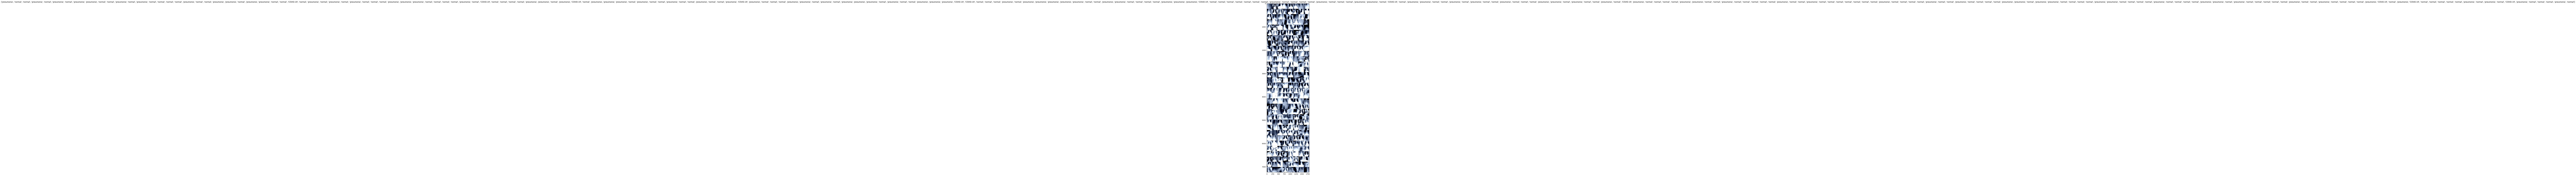

In [4]:

train_dataset = CovidDataset(root='covid_dataset/', split='train',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                        std=[0.229, 0.224, 0.225])
                                                ]))
test_dataset = CovidDataset(root='covid_dataset/', split = 'test',
                                              transform=transforms.Compose([
                                                    transforms.Resize(256),
                                                    transforms.CenterCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                         std=[0.229, 0.224, 0.225])
                                                ]))

print(train_dataset[0])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader= torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)

class_names = train_dataset.classes

def imshow(inp, title = None):
  plt.figure(figsize=(10,20))
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.5])
  std = np.array([0.5])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)

  if title is not None:
    plt.title(title)
  plt.pause(0.001)

inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

device = ('cuda' if torch.cuda.is_available() else 'cpu')

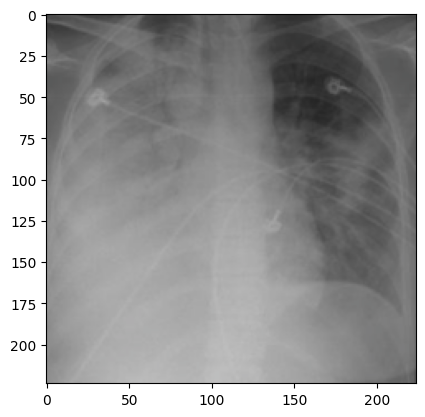

In [5]:
img = test_dataset[3][0]
inp = img.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)


plt.figure()
plt.imshow(inp.squeeze())
plt.show()

In [6]:
def train_model(model, criterio, optimizer, scheduler, num_epochs = 25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)

    #Train model
    scheduler.step()
    model.train()

    running_loss = 0.0
    running_corrects = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss /len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    #Validation
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0

    for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss /len(test_dataset)
    epoch_acc = running_corrects.double() / len(test_dataset)

    print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
  print('Best val accucary: {:.4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model



In [7]:
def visualize_model(model, num_images = 6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far +=1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode = was_training)


In [8]:
model_ft = models.resnet18(pretrained=True)

print(model_ft)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 102MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
import torchsummary as ts

ts.summary(model_ft.to(device), input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [10]:
#Fine tuning
num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 3)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train Loss: 0.6600 Acc: 0.7268
Val Loss: 0.5447 Acc: 0.8214
Epoch 1/24
----------
Train Loss: 0.3947 Acc: 0.8525
Val Loss: 0.4067 Acc: 0.8562
Epoch 2/24
----------
Train Loss: 0.3508 Acc: 0.8698
Val Loss: 0.3870 Acc: 0.8581
Epoch 3/24
----------
Train Loss: 0.3282 Acc: 0.8797
Val Loss: 0.3602 Acc: 0.8664
Epoch 4/24
----------
Train Loss: 0.3113 Acc: 0.8865
Val Loss: 0.3218 Acc: 0.8841
Epoch 5/24
----------
Train Loss: 0.2874 Acc: 0.8922
Val Loss: 0.3057 Acc: 0.8904
Epoch 6/24
----------
Train Loss: 0.2787 Acc: 0.9010
Val Loss: 0.3126 Acc: 0.8835
Epoch 7/24
----------
Train Loss: 0.2750 Acc: 0.8977
Val Loss: 0.3093 Acc: 0.8854
Epoch 8/24
----------
Train Loss: 0.2744 Acc: 0.9014
Val Loss: 0.3046 Acc: 0.8911
Epoch 9/24
----------
Train Loss: 0.2734 Acc: 0.8994
Val Loss: 0.3045 Acc: 0.8917
Epoch 10/24
----------
Train Loss: 0.2703 Acc: 0.9002
Val Loss: 0.3035 Acc: 0.8917
Epoch 11/24
----------
Train Loss: 0.2756 Acc: 0.8966
Val Loss: 0.3026 Acc: 0.8936
Epoch 12/24
----------
Train Loss: 0

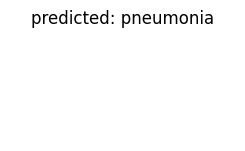

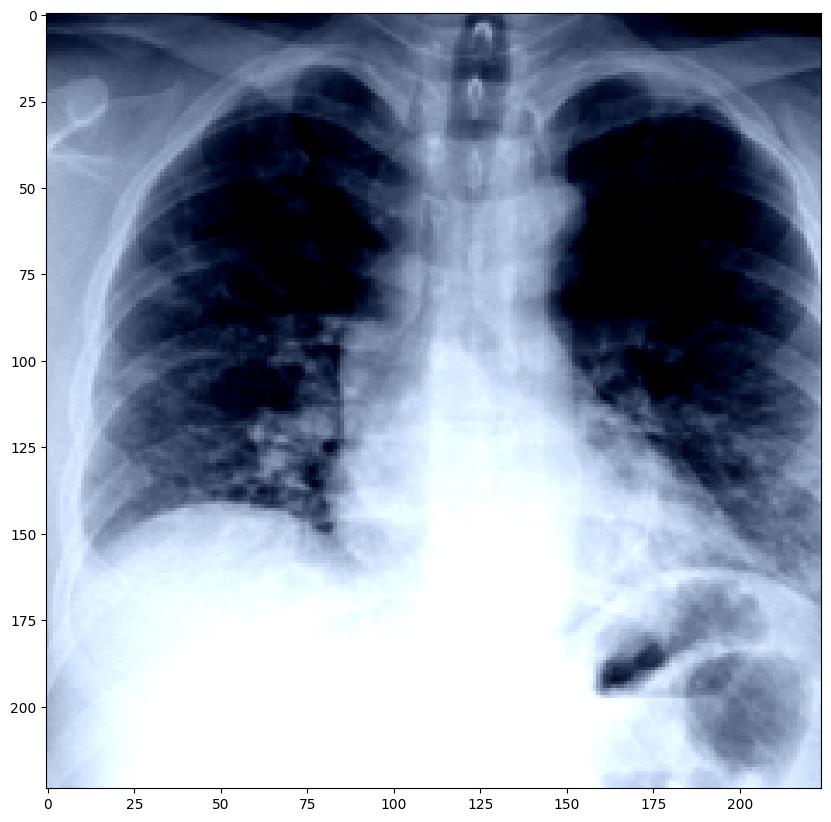

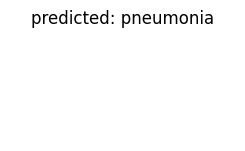

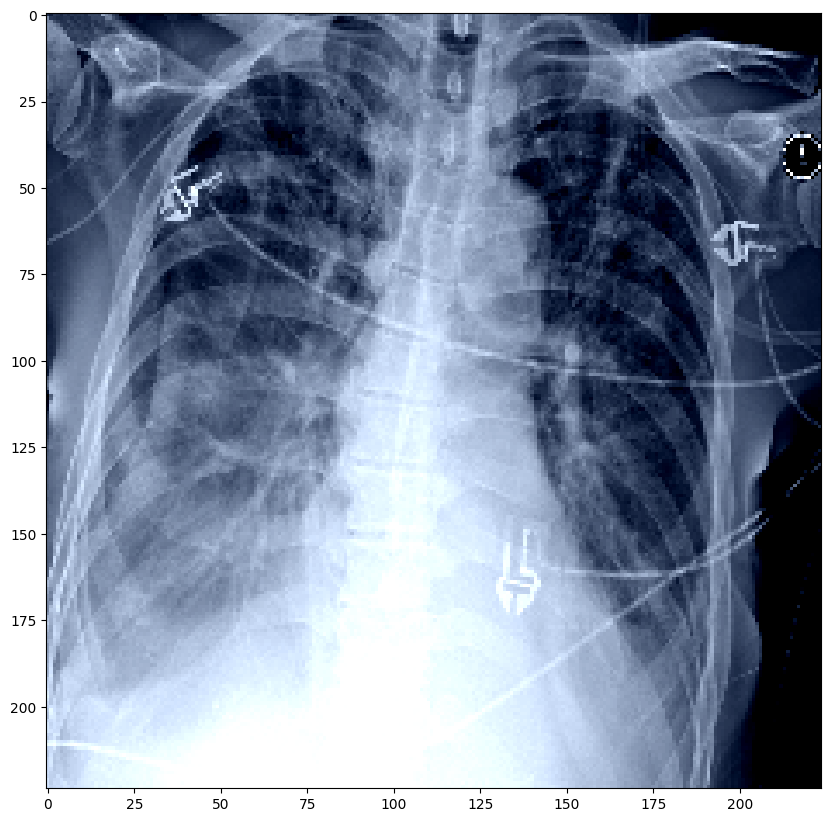

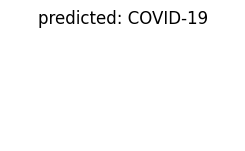

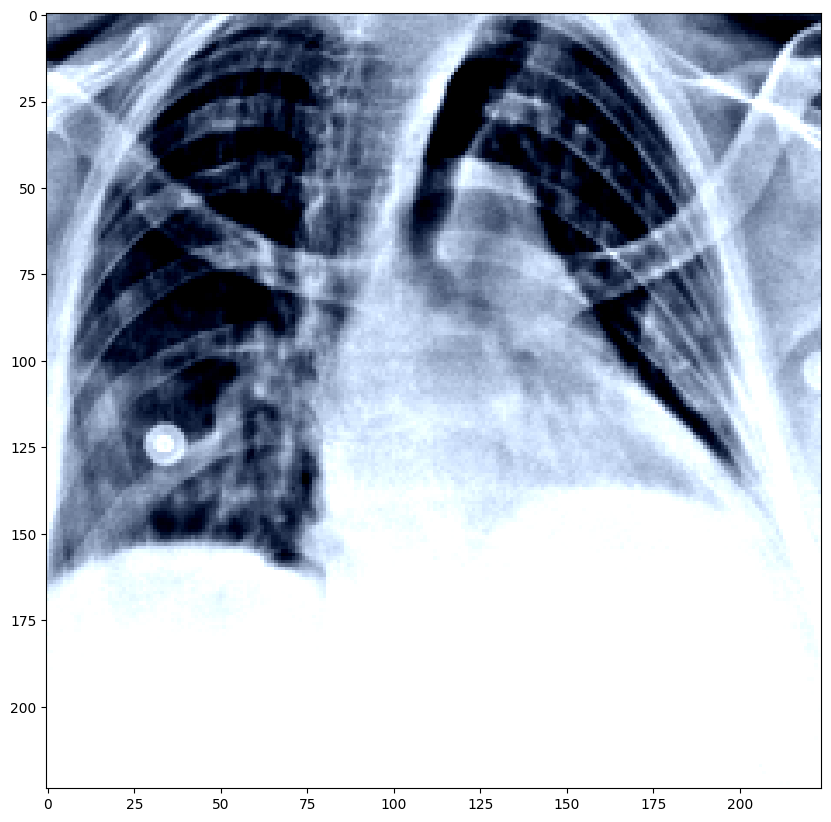

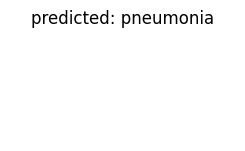

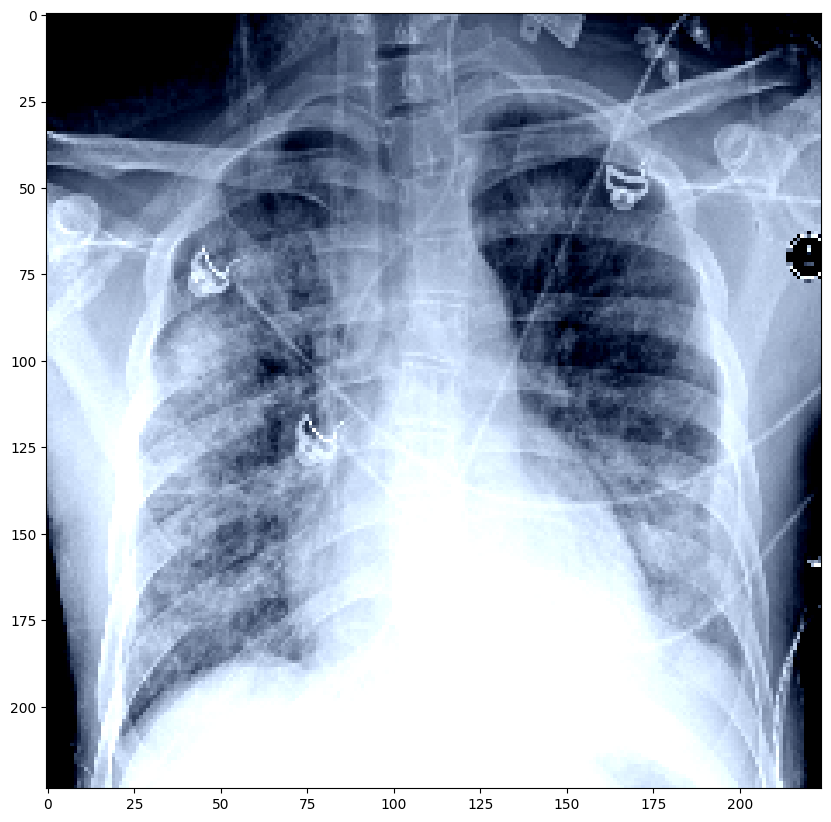

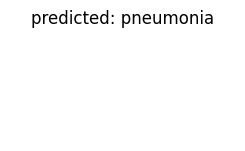

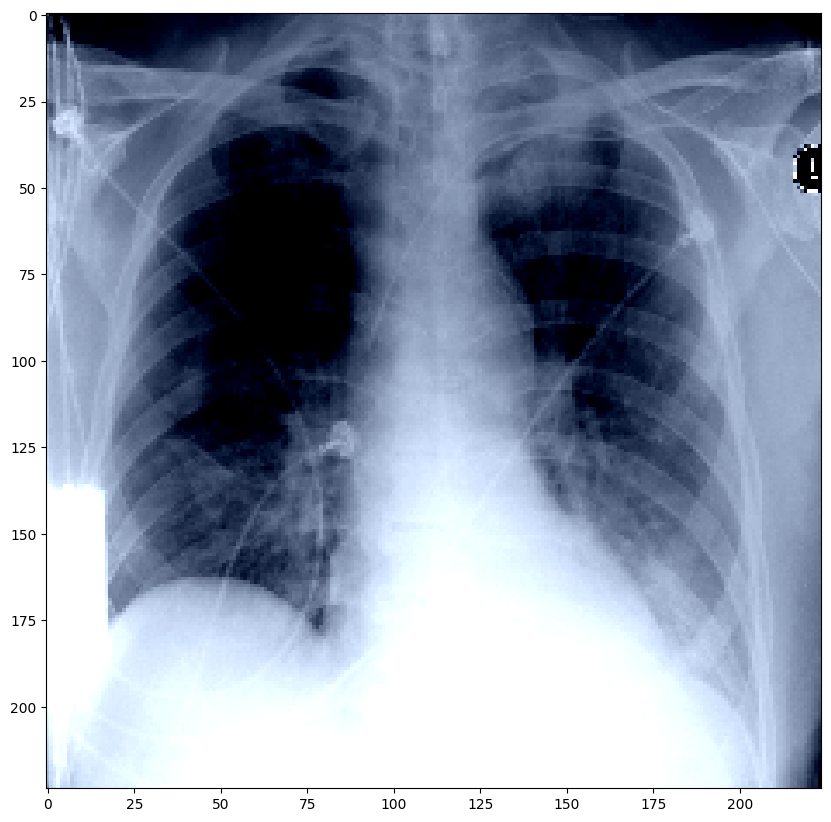

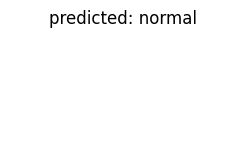

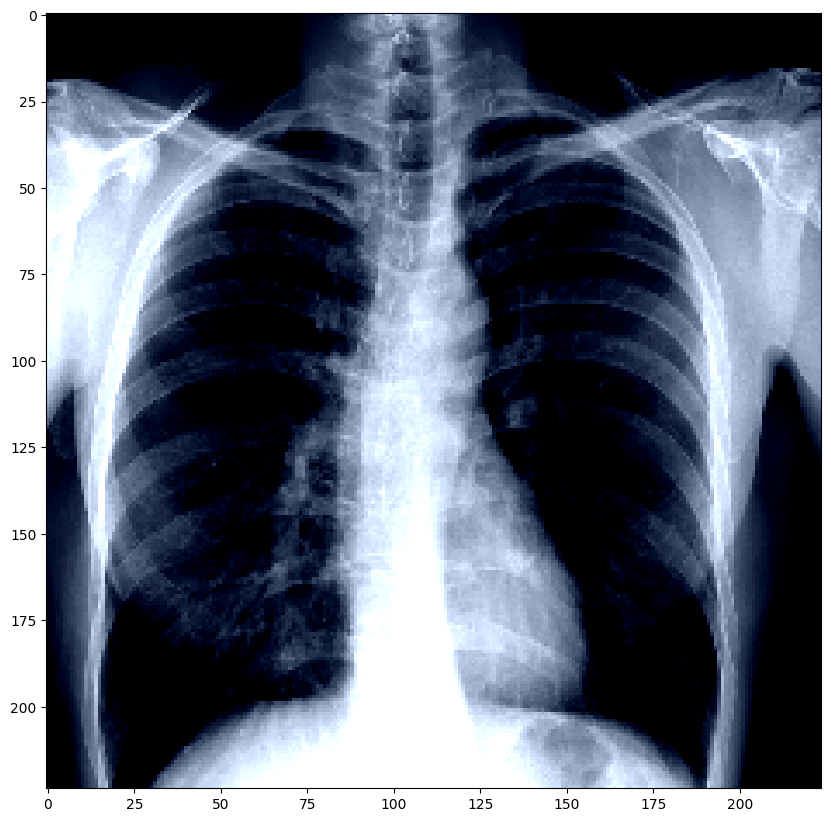

In [11]:
visualize_model(model_ft)

In [12]:
# Freeze
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False

num_ft = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ft,3)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_conv = torch.optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma = 0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Train Loss: 0.6803 Acc: 0.6963
Val Loss: 0.5972 Acc: 0.7834
Epoch 1/24
----------
Train Loss: 0.5153 Acc: 0.8062
Val Loss: 0.5551 Acc: 0.8049
Epoch 2/24
----------
Train Loss: 0.4794 Acc: 0.8185
Val Loss: 0.5397 Acc: 0.8132
Epoch 3/24
----------
Train Loss: 0.4703 Acc: 0.8222
Val Loss: 0.5198 Acc: 0.8163
Epoch 4/24
----------
Train Loss: 0.4543 Acc: 0.8270
Val Loss: 0.5164 Acc: 0.8163
Epoch 5/24
----------
Train Loss: 0.4455 Acc: 0.8305
Val Loss: 0.4960 Acc: 0.8277
Epoch 6/24
----------
Train Loss: 0.4371 Acc: 0.8359
Val Loss: 0.4948 Acc: 0.8265
Epoch 7/24
----------
Train Loss: 0.4345 Acc: 0.8349
Val Loss: 0.4930 Acc: 0.8284
Epoch 8/24
----------
Train Loss: 0.4361 Acc: 0.8335
Val Loss: 0.4901 Acc: 0.8284
Epoch 9/24
----------
Train Loss: 0.4342 Acc: 0.8328
Val Loss: 0.4950 Acc: 0.8258
Epoch 10/24
----------
Train Loss: 0.4281 Acc: 0.8367
Val Loss: 0.4896 Acc: 0.8265
Epoch 11/24
----------
Train Loss: 0.4326 Acc: 0.8374
Val Loss: 0.4874 Acc: 0.8277
Epoch 12/24
--